# Continual Task Finetuning Demo

This notebook demonstrates how to pre-train the flexible multi-task foundation model on non-PI polymers, then load the best checkpoint, freeze the shared encoder, and fine-tune newly added tasks for PI polymers using the dynamic task management utilities (`add_task` / `remove_tasks`).

## Data Overview

- **Descriptors**: `data/amorphous_polymer_FFDescriptor_20250730.parquet`
- **Non-PI properties**: `data/amorphous_polymer_non_PI_properties_20250730.parquet`
- **PI properties**: `data/amorphous_polymer_PI_properties_20250730.parquet`
- Target regression labels (normalized): density, Cp, Rg, linear_expansion

In [1]:
import os
from pathlib import Path
import math
import json
import re

import pandas as pd
import matplotlib.pyplot as plt
import torch
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping
from lightning.pytorch.loggers import CSVLogger

from foundation_model.data.datamodule import CompoundDataModule
from foundation_model.models.flexible_multi_task_model import FlexibleMultiTaskModel
from foundation_model.models.model_config import RegressionTaskConfig, TaskType, OptimizerConfig, TransformerEncoderConfig


2025-11-06 06:53:54.488 | INFO     | __init__:<module>:34 - Loguru logger initialized for foundation_model package.


In [2]:
DATA_DIR = Path("../data")
DESCRIPTOR_PATH = DATA_DIR / "amorphous_polymer_FFDescriptor_20250730.parquet"
NON_PI_PATH = DATA_DIR / "amorphous_polymer_non_PI_properties_20250730.parquet"
PI_PATH = DATA_DIR / "amorphous_polymer_PI_properties_20250730.parquet"

use_normalized_targets = True  # set to True to use normalized targets

TARGET_COLUMNS = {
    "density": f"density{' (normalized)' if use_normalized_targets else ''}",
    "Cp": f"Cp{' (normalized)' if use_normalized_targets else ''}",
    "Rg": f"Rg{' (normalized)' if use_normalized_targets else ''}",
    "linear_expansion": f"linear_expansion{' (normalized)' if use_normalized_targets else ''}",
}

SHARED_BLOCK_DIMS = [190, 256, 128]
ENCODER_CONFIG: TransformerEncoderConfig | None = None  # set to TransformerEncoderConfig(...) to try the transformer backbone
LATENT_WIDTH = getattr(ENCODER_CONFIG, "latent_dim", SHARED_BLOCK_DIMS[-1])
HEAD_HIDDEN = 64  # hidden width for regression heads
ARTIFACT_ROOT = Path("../artifacts/polymers_dynamic_tasks")
ARTIFACT_ROOT.mkdir(parents=True, exist_ok=True)

PRETRAIN_SAMPLE = 200_000  # subset for quick demonstration
PI_SAMPLE = None  # use full PI set by default


In [3]:
descriptor_df = pd.read_parquet(DESCRIPTOR_PATH)
non_pi_df = pd.read_parquet(NON_PI_PATH)
pi_df = pd.read_parquet(PI_PATH)

common_non_pi = descriptor_df.index.intersection(non_pi_df.index)
pretrain_features = descriptor_df.loc[common_non_pi]
pretrain_targets = non_pi_df.loc[common_non_pi, list(TARGET_COLUMNS.values())]

if PRETRAIN_SAMPLE is not None and PRETRAIN_SAMPLE < len(pretrain_features):
    pretrain_features = pretrain_features.sample(n=PRETRAIN_SAMPLE, random_state=42)
    pretrain_targets = pretrain_targets.loc[pretrain_features.index]

common_pi = descriptor_df.index.intersection(pi_df.index)
pi_features = descriptor_df.loc[common_pi]
pi_targets = pi_df.loc[common_pi, list(TARGET_COLUMNS.values())]

if PI_SAMPLE is not None and PI_SAMPLE < len(pi_features):
    pi_features = pi_features.sample(n=PI_SAMPLE, random_state=13)
    pi_targets = pi_targets.loc[pi_features.index]

print(f"Pre-train feature tensor: {pretrain_features.shape}")
print(f"Pre-train targets: {pretrain_targets.shape}")
print(f"Fine-tune feature tensor: {pi_features.shape}")
print(f"Fine-tune targets: {pi_targets.shape}")

Pre-train feature tensor: (71725, 190)
Pre-train targets: (71725, 4)
Fine-tune feature tensor: (1083, 190)
Fine-tune targets: (1083, 4)


## Build Task Configurations

In [4]:
def build_regression_task(name: str, column: str) -> RegressionTaskConfig:
    return RegressionTaskConfig(
        name=name,
        data_column=column,
        dims=[LATENT_WIDTH, HEAD_HIDDEN, 1],
        norm=True,
        residual=False,
    )

pretrain_task_configs = [build_regression_task(name, col) for name, col in TARGET_COLUMNS.items()]
pi_task_configs = [build_regression_task(f"{name} (PI)", col) for name, col in TARGET_COLUMNS.items()]

print("Pretrain tasks:", [cfg.name for cfg in pretrain_task_configs])
print("PI tasks:", [cfg.name for cfg in pi_task_configs])


Pretrain tasks: ['density', 'Cp', 'Rg', 'linear_expansion']
PI tasks: ['density (PI)', 'Cp (PI)', 'Rg (PI)', 'linear_expansion (PI)']


In [5]:
def plot_test_predictions(
    model: FlexibleMultiTaskModel,
    datamodule: CompoundDataModule,
    stage_label: str,
    device: str | None = None,
    artifact_dir: Path | str | None = None,
) -> None:
    """Render predicted vs. actual scatter plots and persist evaluation artifacts."""
    if device is None:
        if torch.cuda.is_available():
            device = "cuda"
        elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
            device = "mps"
        else:
            device = "cpu"

    datamodule.setup(stage="test")
    test_loader = datamodule.test_dataloader()
    if test_loader is None:
        raise RuntimeError(f"{stage_label} datamodule does not define a test_dataloader().")

    artifact_base = Path(artifact_dir) if artifact_dir is not None else ARTIFACT_ROOT
    artifact_base.mkdir(parents=True, exist_ok=True)
    stage_slug = re.sub(r"[^a-z0-9]+", "_", stage_label.lower()).strip("_")
    if not stage_slug:
        stage_slug = "stage"
    stage_dir = artifact_base / stage_slug
    stage_dir.mkdir(parents=True, exist_ok=True)
    metrics_path = stage_dir / "metrics.json"
    predictions_path = stage_dir / "predictions.csv"

    original_device = next(model.parameters()).device
    was_training = model.training

    model = model.to(device)
    model.eval()

    aggregated: dict[str, dict[str, list[torch.Tensor]]] = {}
    csv_rows: list[dict[str, float | str | int]] = []
    per_task_counts: dict[str, int] = {}

    with torch.no_grad():
        for batch in test_loader:
            x, y_dict, mask_dict, t_sequences = batch
            x = x.to(device)
            preds = model(x, t_sequences)

            for name, pred_tensor in preds.items():
                if name not in y_dict:
                    continue

                target_tensor = y_dict[name]
                mask_tensor = mask_dict.get(name)

                if isinstance(target_tensor, list):
                    target_flat = torch.cat([t.detach().cpu().reshape(-1) for t in target_tensor])
                else:
                    target_flat = target_tensor.detach().cpu().reshape(-1)

                pred_flat = pred_tensor.detach().cpu().reshape(-1)

                if mask_tensor is not None:
                    if isinstance(mask_tensor, list):
                        mask_flat = torch.cat([m.detach().cpu().reshape(-1) for m in mask_tensor])
                    else:
                        mask_flat = mask_tensor.detach().cpu().reshape(-1)
                    mask_flat = mask_flat.bool()
                    target_flat = target_flat[mask_flat]
                    pred_flat = pred_flat[mask_flat]

                if target_flat.numel() == 0:
                    continue

                entry = aggregated.setdefault(name, {"preds": [], "targets": []})
                entry["preds"].append(pred_flat)
                entry["targets"].append(target_flat)

                start_idx = per_task_counts.get(name, 0)
                for offset, (actual_val, pred_val) in enumerate(zip(target_flat.tolist(), pred_flat.tolist())):
                    csv_rows.append(
                        {
                            "stage": stage_label,
                            "task": name,
                            "sample_index": start_idx + offset,
                            "actual": actual_val,
                            "predicted": pred_val,
                        }
                    )
                per_task_counts[name] = start_idx + target_flat.numel()

    if not aggregated:
        print(f"No test predictions available for {stage_label}.")
        model.to(original_device)
        if was_training:
            model.train()
        return

    metrics: dict[str, dict[str, float | int | None]] = {}
    items = sorted(aggregated.items())
    num_tasks = len(items)
    cols = 2 if num_tasks > 1 else 1
    rows = math.ceil(num_tasks / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4.5, rows * 4.5))
    axes_list = axes.flatten().tolist() if hasattr(axes, "flatten") else [axes]

    for ax, (name, data) in zip(axes_list, items):
        preds = torch.cat(data["preds"])
        targets = torch.cat(data["targets"])
        diff = preds - targets
        mae = torch.mean(torch.abs(diff)).item()
        mse = torch.mean(diff ** 2).item()
        rmse = torch.sqrt(torch.mean(diff ** 2)).item()
        ss_tot = torch.sum((targets - targets.mean()) ** 2).item()
        ss_res = torch.sum(diff ** 2).item()
        r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else None

        metrics[name] = {
            "samples": int(targets.numel()),
            "mae": mae,
            "mse": mse,
            "rmse": rmse,
            "r2": r2,
        }

        preds_np = preds.numpy()
        targets_np = targets.numpy()
        lo = float(min(preds_np.min(), targets_np.min()))
        hi = float(max(preds_np.max(), targets_np.max()))
        buffer = 0.05 * (hi - lo) if hi > lo else 0.1
        lo -= buffer
        hi += buffer

        ax.scatter(targets_np, preds_np, s=12, alpha=0.6, edgecolors="none")
        ax.plot([lo, hi], [lo, hi], "--", color="tab:red", linewidth=1)
        annotation = f"MAE: {mae:.3f} R²: {r2:.3f}" if r2 is not None else f"MAE: {mae:.3f}"
        ax.text(0.05, 0.95, annotation, transform=ax.transAxes, fontsize=10,
                verticalalignment="top", bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.6))
        ax.set_xlim(lo, hi)
        ax.set_ylim(lo, hi)
        ax.set_xlabel("Actual")
        ax.set_ylabel("Predicted")
        ax.set_title(f"{stage_label}: {name}")
        ax.grid(alpha=0.2)
        ax.set_aspect("equal", adjustable="box")

    for ax in axes_list[len(items):]:
        ax.axis("off")

    fig.tight_layout()
    plt.show()

    if csv_rows:
        pd.DataFrame(csv_rows).to_csv(predictions_path, index=False)
        print(f"Saved predictions to {predictions_path}")

    with open(metrics_path, "w", encoding="utf-8") as f:
        json.dump(metrics, f, indent=2)
    print(f"Saved metrics to {metrics_path}")

    model.to(original_device)
    if was_training:
        model.train()


## Stage 1 — Pre-train on non-PI polymers

In [6]:
pretrain_datamodule = CompoundDataModule(
    formula_desc_source=pretrain_features,
    attributes_source=pretrain_targets,
    task_configs=pretrain_task_configs,
    batch_size=256,
    num_workers=0,
    # val_split=0.1,
    # test_split=0.1,
)

pretrain_model = FlexibleMultiTaskModel(
    shared_block_dims=SHARED_BLOCK_DIMS,
    task_configs=pretrain_task_configs,
    encoder_config=ENCODER_CONFIG,
    enable_learnable_loss_balancer=True,
    # enable_learnable_loss_balancer=False,
    shared_block_optimizer=OptimizerConfig(lr=5e-2)
)

pretrain_checkpoint_dir = ARTIFACT_ROOT / "pretrain_checkpoints"
pretrain_checkpoint_dir.mkdir(parents=True, exist_ok=True)
pretrain_ckpt = ModelCheckpoint(
    dirpath=pretrain_checkpoint_dir,
    filename="pretrain-{epoch:02d}-{val_final_loss:.4f}",
    monitor="val_final_loss",
    mode="min",
    save_top_k=1,
)

pretrain_logger = CSVLogger(save_dir=ARTIFACT_ROOT / "logs", name="pretrain")

pretrain_early_stopping = EarlyStopping(
    monitor="val_final_loss",
    mode="min",
    patience=10,
)

pretrain_trainer = Trainer(
    max_epochs=1000,
    accelerator="auto",
    devices="auto",
    callbacks=[pretrain_ckpt, pretrain_early_stopping],
    logger=pretrain_logger,
    # log_every_n_steps=10,
    # limit_train_batches=0.2,
    # limit_val_batches=0.5,
)

pretrain_trainer.fit(pretrain_model, datamodule=pretrain_datamodule)
print(f"Best checkpoint: {pretrain_ckpt.best_model_path}")


2025-11-06 06:53:56.154 | INFO     | datamodule:__init__:157 - Initializing CompoundDataModule...
2025-11-06 06:53:56.155 | INFO     | datamodule:__init__:194 - --- Loading Data ---
2025-11-06 06:53:56.155 | INFO     | datamodule:_load_data:468 - Using provided pd.DataFrame for 'formula_desc' data.
2025-11-06 06:53:56.178 | INFO     | datamodule:_load_data:475 - Successfully loaded 'formula_desc'. Shape: (71725, 190)
2025-11-06 06:53:56.179 | INFO     | datamodule:__init__:199 - Initial loaded formula_df length: 71725
2025-11-06 06:53:56.209 | INFO     | datamodule:__init__:206 - Formula_df length after initial dropna: 71725. This index is now the master reference.
2025-11-06 06:53:56.209 | INFO     | datamodule:_load_data:468 - Using provided pd.DataFrame for 'attributes' data.
2025-11-06 06:53:56.210 | INFO     | datamodule:_load_data:475 - Successfully loaded 'attributes'. Shape: (71725, 4)
2025-11-06 06:53:56.210 | INFO     | datamodule:__init__:220 - Initial loaded attributes_df l

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 284: 100%|██████████| 225/225 [00:05<00:00, 39.72it/s, v_num=1, train_final_loss_step=0.0023, val_final_loss=-1.76, train_final_loss_epoch=-1.80]   
Best checkpoint: /Users/liuchang/projects/foundation_model/artifacts/polymers_dynamic_tasks/pretrain_checkpoints/pretrain-epoch=274-val_final_loss=-1.7778.ckpt


### Pre-train test evaluation


In [7]:
torch.serialization.add_safe_globals([RegressionTaskConfig, TaskType, OptimizerConfig, TransformerEncoderConfig])


## Stage 2 — Fine-tune newly added PI tasks

In [8]:
torch.serialization.add_safe_globals([RegressionTaskConfig, TaskType, OptimizerConfig, TransformerEncoderConfig])

pi_datamodule = CompoundDataModule(
    formula_desc_source=pi_features,
    attributes_source=pi_targets,
    task_configs=pi_task_configs,
    batch_size=64,
    num_workers=0,
    # val_split=0.2,
    # test_split=0.0,
)

# finetune_model = FlexibleMultiTaskModel(
#     shared_block_dims=SHARED_BLOCK_DIMS,
#    task_configs=pretrain_task_configs,
#    encoder_config=ENCODER_CONFIG,
#    enable_learnable_loss_balancer=True,
#    freeze_shared_encoder=True,
# )

best_ckpt_path = pretrain_ckpt.best_model_path
if not best_ckpt_path:
    raise RuntimeError("Pre-training did not produce a checkpoint. Check earlier cells for errors.")

# state = torch.load(best_ckpt_path, map_location="mps", weights_only=True)
# finetune_model.load_state_dict(state["state_dict"], strict=False)

finetune_model = FlexibleMultiTaskModel.load_from_checkpoint(
    checkpoint_path=best_ckpt_path,
    strict=False,
    freeze_shared_encoder=True,
    encoder_config=ENCODER_CONFIG,
)
finetune_model.remove_tasks(*TARGET_COLUMNS.keys())
finetune_model.add_task(*pi_task_configs)

print("Trainable task heads:", list(finetune_model.task_heads.keys()))


2025-11-06 07:21:10.760 | INFO     | datamodule:__init__:157 - Initializing CompoundDataModule...
2025-11-06 07:21:10.761 | INFO     | datamodule:__init__:194 - --- Loading Data ---
2025-11-06 07:21:10.761 | INFO     | datamodule:_load_data:468 - Using provided pd.DataFrame for 'formula_desc' data.
2025-11-06 07:21:10.762 | INFO     | datamodule:_load_data:475 - Successfully loaded 'formula_desc'. Shape: (1083, 190)
2025-11-06 07:21:10.762 | INFO     | datamodule:__init__:199 - Initial loaded formula_df length: 1083
2025-11-06 07:21:10.764 | INFO     | datamodule:__init__:206 - Formula_df length after initial dropna: 1083. This index is now the master reference.
2025-11-06 07:21:10.764 | INFO     | datamodule:_load_data:468 - Using provided pd.DataFrame for 'attributes' data.
2025-11-06 07:21:10.764 | INFO     | datamodule:_load_data:475 - Successfully loaded 'attributes'. Shape: (1083, 4)
2025-11-06 07:21:10.765 | INFO     | datamodule:__init__:220 - Initial loaded attributes_df lengt

Trainable task heads: ['density (PI)', 'Cp (PI)', 'Rg (PI)', 'linear_expansion (PI)']


In [9]:
finetune_checkpoint_dir = ARTIFACT_ROOT / "finetune_checkpoints"
finetune_checkpoint_dir.mkdir(parents=True, exist_ok=True)
finetune_ckpt = ModelCheckpoint(
    dirpath=finetune_checkpoint_dir,
    filename="finetune-{epoch:02d}-{val_final_loss:.4f}",
    monitor="val_final_loss",
    mode="min",
    save_top_k=1,
)

finetune_logger = CSVLogger(save_dir=ARTIFACT_ROOT / "logs", name="finetune")

finetune_early_stopping = EarlyStopping(
    monitor="val_final_loss",
    mode="min",
    patience=10,
)

finetune_trainer = Trainer(
    max_epochs=200,
    accelerator="auto",
    devices="auto",
    callbacks=[finetune_ckpt, finetune_early_stopping],
    logger=finetune_logger,
    log_every_n_steps=5,
    limit_train_batches=1.0,
    limit_val_batches=1.0,
)

finetune_trainer.fit(finetune_model, datamodule=pi_datamodule)
print(f"Best fine-tuning checkpoint: {finetune_ckpt.best_model_path}")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
2025-11-06 07:21:10.905 | INFO     | datamodule:setup:590 - --- Setting up DataModule for stage: TrainerFn.FITTING ---
2025-11-06 07:21:10.905 | INFO     | datamodule:setup:600 - Total samples available before splitting (from attributes_df index): 1083
2025-11-06 07:21:10.906 | INFO     | datamodule:setup:633 - Data split strategy: Performing random train/val/test splits based on full_idx (derived from attributes_df).
2025-11-06 07:21:10.906 | INFO     | datamodule:setup:636 - Test split ratio: 0.1, Validation split ratio (of non-test): 0.1
2025-11-06 07:21:10.906 | INFO     | datamodule:setup:648 - Split full data (1083) into train_val (974) and test (109) using derived seed 10042 (base rand

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/Users/liuchang/projects/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 31: 100%|██████████| 14/14 [00:00<00:00, 43.42it/s, v_num=0, train_final_loss_step=-2.38, val_final_loss=-2.04, train_final_loss_epoch=-1.93]  
Best fine-tuning checkpoint: /Users/liuchang/projects/foundation_model/artifacts/polymers_dynamic_tasks/finetune_checkpoints/finetune-epoch=21-val_final_loss=-2.0526.ckpt


2025-11-06 07:21:22.374 | INFO     | datamodule:setup:590 - --- Setting up DataModule for stage: test ---
2025-11-06 07:21:22.374 | INFO     | datamodule:setup:600 - Total samples available before splitting (from attributes_df index): 1083
2025-11-06 07:21:22.374 | INFO     | datamodule:setup:633 - Data split strategy: Performing random train/val/test splits based on full_idx (derived from attributes_df).
2025-11-06 07:21:22.375 | INFO     | datamodule:setup:636 - Test split ratio: 0.1, Validation split ratio (of non-test): 0.1
2025-11-06 07:21:22.375 | INFO     | datamodule:setup:648 - Split full data (1083) into train_val (974) and test (109) using derived seed 10042 (base random_seed=42).
2025-11-06 07:21:22.376 | INFO     | datamodule:setup:675 - Split train_val (974) into train (865) and val (109) using derived seed 42 (base random_seed=42), effective_val_split 0.111.
2025-11-06 07:21:22.376 | INFO     | datamodule:setup:703 - Final dataset sizes after splitting: Train=865, Valida

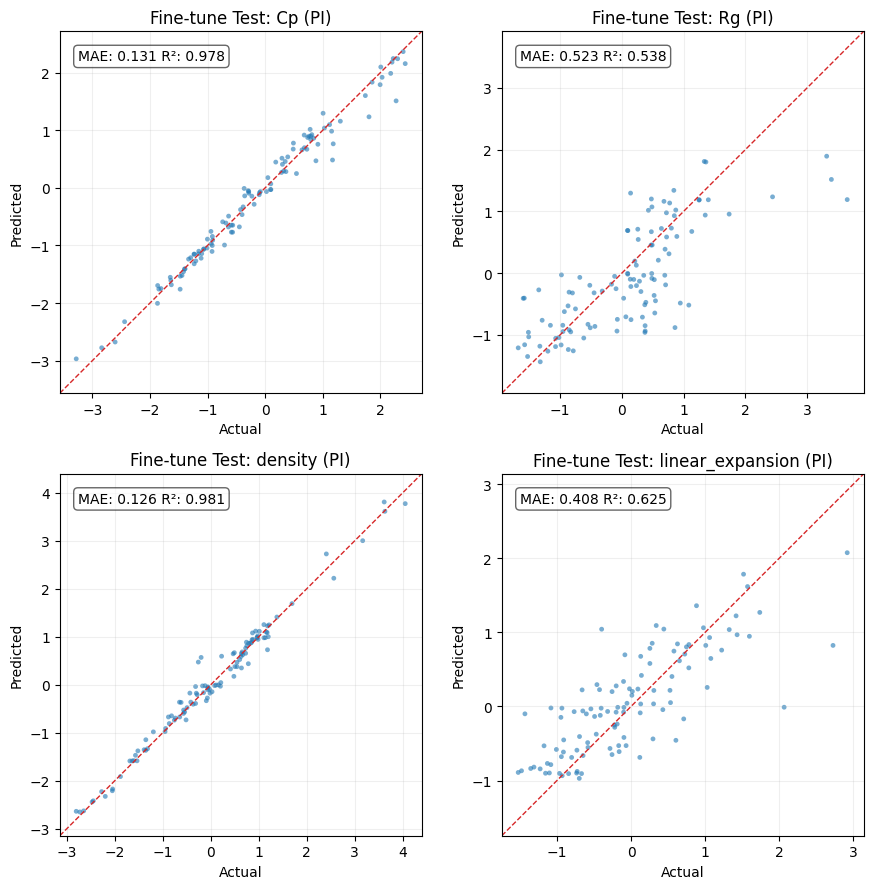

Saved predictions to ../artifacts/polymers_dynamic_tasks/fine_tune_test/predictions.csv
Saved metrics to ../artifacts/polymers_dynamic_tasks/fine_tune_test/metrics.json


In [10]:
if finetune_ckpt.best_model_path:
    finetune_state = torch.load(finetune_ckpt.best_model_path, map_location="cpu", weights_only=True)
    finetune_state_dict = finetune_state.get("state_dict", finetune_state)
    finetune_model.load_state_dict(finetune_state_dict)
else:
    print("No best checkpoint found for fine-tuning; using current model weights.")

plot_test_predictions(finetune_model, pi_datamodule, "Fine-tune Test", artifact_dir=ARTIFACT_ROOT)


## Inspect fine-tuned predictions

In [11]:
pi_datamodule.setup(stage="test")
val_loader = pi_datamodule.test_dataloader()
example_batch = next(iter(val_loader))

with torch.no_grad():
    outputs = finetune_model(example_batch[0], example_batch[3])

for name, tensor in outputs.items():
    print(name, tensor[:5].squeeze().cpu().numpy())

2025-11-06 07:21:22.616 | INFO     | datamodule:setup:590 - --- Setting up DataModule for stage: test ---
2025-11-06 07:21:22.616 | INFO     | datamodule:setup:600 - Total samples available before splitting (from attributes_df index): 1083
2025-11-06 07:21:22.617 | INFO     | datamodule:setup:633 - Data split strategy: Performing random train/val/test splits based on full_idx (derived from attributes_df).
2025-11-06 07:21:22.617 | INFO     | datamodule:setup:636 - Test split ratio: 0.1, Validation split ratio (of non-test): 0.1
2025-11-06 07:21:22.618 | INFO     | datamodule:setup:648 - Split full data (1083) into train_val (974) and test (109) using derived seed 10042 (base random_seed=42).
2025-11-06 07:21:22.618 | INFO     | datamodule:setup:675 - Split train_val (974) into train (865) and val (109) using derived seed 42 (base random_seed=42), effective_val_split 0.111.
2025-11-06 07:21:22.618 | INFO     | datamodule:setup:703 - Final dataset sizes after splitting: Train=865, Valida

density (PI) [-1.2357726  -1.7286263  -0.1261941  -0.31501198  0.8865948 ]
Cp (PI) [ 0.9768045   0.92937326  0.44217288  0.6128504  -1.2413336 ]
Rg (PI) [-1.1959804  -0.5558122  -0.03839028 -0.66122216  0.01823133]
linear_expansion (PI) [ 0.3163443   0.2506983  -0.0567692  -0.07728253 -0.4267617 ]
